In [1]:
# parameters
rho = 1000  # k/m3
H_0_mean = 2.5  # m
H_0_min = 0.1  # m
delta_t = 5 * 60  # s
epsilon_0_mean = 1 / 3 / 3600  # 1 / s
epsilon_1 = 1 / 5 / 24 / 3600  # 1 / s
H_0_plus_H_1 = 30  # m
delta = 0.1  # fraction of momentum flux from u_0 which is _not_ going into u_1
lat = 10  # deg N

tau_x = 0.2  # kg / m / s2
tau_y = 0

time_reference = "2001-01-01 00:00"
num_timesteps = 30 * 1 * 288 + 1  # that's 30 days at 5 min timesteps

rng_seed = 12345

In [2]:
import numpy as np

In [3]:
np.random.seed(rng_seed)

In [4]:
f_30N = 2 * np.pi / 24 / 3600  # 2π / d (at 30N)

f = f_30N / np.sin(np.deg2rad(30)) * np.sin(np.deg2rad(lat))

In [5]:
import xarray as xr

In [6]:
ds_tau = xr.Dataset(
    {
        "tau_x": ("time", np.random.normal(0, 0.2, size=(121 + 2, ))),
        "tau_y": ("time", np.random.normal(0, 0.2, size=(121 + 2, ))),
    },
    coords={
        "time": (
            "time",
            np.datetime64(time_reference)  # 6h time steps
            + np.arange(-1, 121 + 1) * np.timedelta64(6 * 3600, "s")
        ),
    },
).rolling(time=3, center=True).mean().dropna("time")

ds_tau

/tmp/ipykernel_3374/93679419.py:1: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds_tau = xr.Dataset(


<xarray.Dataset>
Dimensions:  (time: 121)
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 2001-01-01T06:00:00 ... 2001-01-31
Data variables:
    tau_x    (time) float64 -0.01635 -0.03975 0.05937 ... -0.3379 -0.2044
    tau_y    (time) float64 0.01923 -0.0204 -0.04254 ... 0.08922 -0.04568

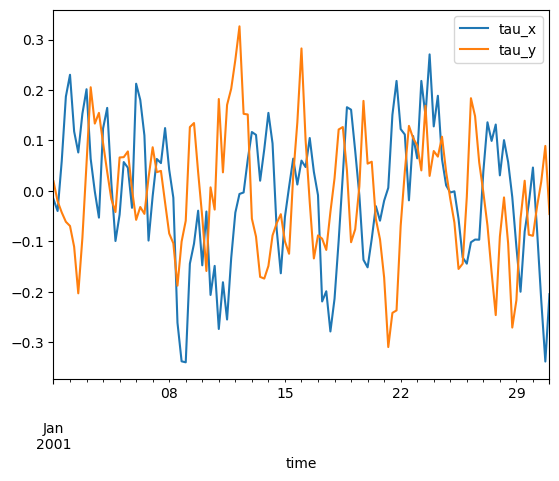

In [7]:
ds_tau.to_pandas().plot();

In [8]:
time = xr.DataArray(
    np.datetime64(time_reference) + np.arange(num_timesteps) * np.timedelta64(delta_t, "s"),
    dims=("time", ),
)
time = time.assign_coords(time=time)

time

/tmp/ipykernel_3374/2029799797.py:1: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  time = xr.DataArray(


<xarray.DataArray (time: 8641)>
array(['2001-01-01T00:00:00.000000000', '2001-01-01T00:05:00.000000000',
       '2001-01-01T00:10:00.000000000', ...,
       '2001-01-30T23:50:00.000000000', '2001-01-30T23:55:00.000000000',
       '2001-01-31T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 2001-01-01T00:05:00 ... 2001-01-31

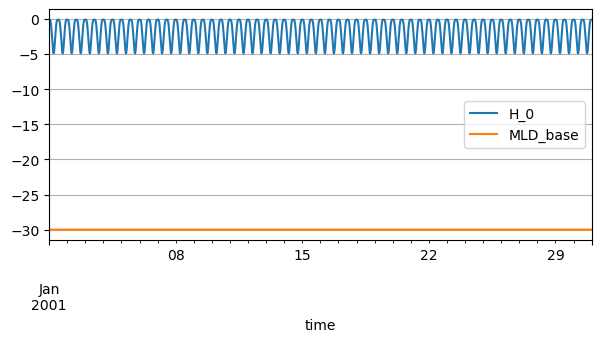

In [9]:
H_0 = (
    H_0_min
    + 2 * (H_0_mean - H_0_min) * np.sin(
        2 * np.pi * 
        ((time - time.isel(time=0)) / np.timedelta64(24 * 3600, "s"))
    ) ** 4
).rename("H_0")

H_1 = (H_0_plus_H_1 - H_0).rename("H_1")

ax = (- H_0).to_pandas().plot(label="H_0", legend=True, figsize=(7, 3))
(- H_0 - H_1).to_pandas().plot(ax=ax, label="MLD_base", legend=True, grid=True);

In [10]:
u_0_x = xr.zeros_like(time, dtype=float).rename("u_0_x")
u_0_y = xr.zeros_like(time, dtype=float).rename("u_0_y")
u_1_x = xr.zeros_like(time, dtype=float).rename("u_1_x")
u_1_y = xr.zeros_like(time, dtype=float).rename("u_1_y")

In [32]:
def integrate(
    u_0_x=None, u_0_y=None,
    u_1_x=None, u_1_y=None,
    H_0=None, H_1=None,
    ds_tau=None,
):
    u_0_x_arr = u_0_x.data.copy()
    u_0_y_arr = u_0_y.data.copy()
    u_1_x_arr = u_1_x.data.copy()
    u_1_y_arr = u_1_y.data.copy()
    tau = ds_tau.interp_like(u_0_x.time)
    for l in range(1, len(u_0_x_arr)):
        u_0_x_arr[l, ...] = (
            delta_t * tau.tau_x.isel(time=l-1).data / rho / H_0.isel(time=l-1).data
            + (1 - delta_t * epsilon_0_mean * H_0_mean / H_0.isel(time=l-1).data) * u_0_x_arr[l-1, ...]
            + delta_t * f * u_0_y_arr[l-1, ...]
        )
        u_0_y_arr[l, ...] = (
            delta_t * tau.tau_y.isel(time=l-1).data / rho / H_0.isel(time=l-1).data
            + (1 - delta_t * epsilon_0_mean * H_0_mean / H_0.isel(time=l-1).data) * u_0_y_arr[l-1, ...]
            - delta_t * f * u_0_x_arr[l-1, ...]
        )
        
        u_1_x_arr[l, ...] = (
            (1-delta) * delta_t * epsilon_0_mean * H_0_mean / H_1.isel(time=l-1).data * u_0_x_arr[l-1, ...]
            + (1 - delta_t * epsilon_1) * u_1_x_arr[l-1, ...]
            + delta_t * f * u_1_y_arr[l-1, ...]
        )
        u_1_y_arr[l, ...] = (
            (1-delta) * delta_t * epsilon_0_mean * H_0_mean / H_1.isel(time=l-1).data * u_0_y_arr[l-1, ...]
            + (1 - delta_t * epsilon_1) * u_1_y_arr[l-1, ...]
            - delta_t * f * u_1_x_arr[l-1, ...]
        )
        
    return xr.Dataset(
        {
            "u_0_x": xr.ones_like(u_0_x) * u_0_x_arr,
            "u_0_y": xr.ones_like(u_0_y) * u_0_y_arr,
            "u_0_spd": xr.ones_like(u_0_y) * (u_0_x_arr ** 2 + u_0_y_arr ** 2) ** 0.5,
            "u_1_x": xr.ones_like(u_1_x) * u_1_x_arr,
            "u_1_y": xr.ones_like(u_1_y) * u_1_y_arr,
            "u_1_spd": xr.ones_like(u_1_y) * (u_1_x_arr ** 2 + u_1_y_arr ** 2) ** 0.5,
            "tau_x": tau.tau_x,
            "tau_y": tau.tau_y,
            "WPI": tau.tau_x * u_0_x_arr + tau.tau_y * u_0_y_arr,
            "H_0": H_0,
            "H_1": H_1,
        }
    )

In [33]:
ds_integrated = integrate(
    u_0_x=u_0_x,
    u_0_y=u_0_y,
    u_1_x=u_1_x,
    u_1_y=u_1_y,
    H_0=H_0,
    H_1=H_1,
    ds_tau=ds_tau,
)

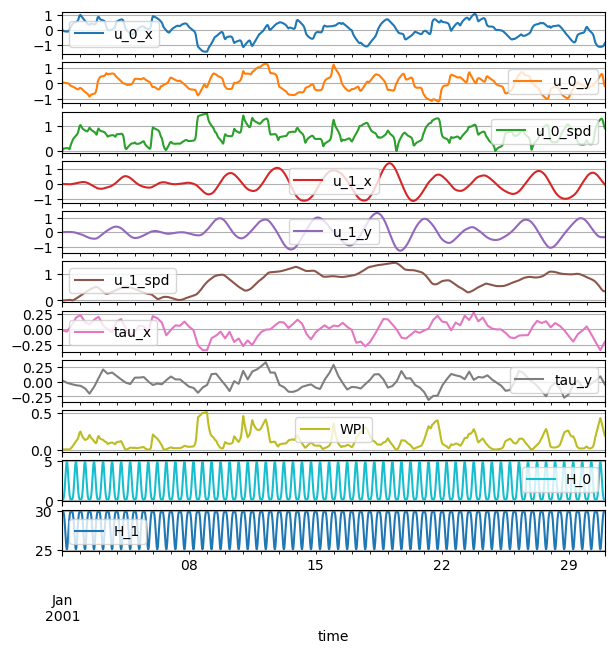

In [34]:
ax = ds_integrated.to_pandas().plot(grid=True, figsize=(7, 7), subplots=True);